# **Master in Artificial Intelligence - UPC**

## ATCI - Advanced Topics in Computational Intelligence

### DDPG (Deep Deterministic Policy Gradient) implementation

#### Done by Armando Rodriguez Ramos

The implementation is based on the "*Continuous control with deep reinforcement learning*" paper that can be found [here](https://arxiv.org/abs/1509.02971). All references to the original algorithm, method, or implementation will refer to this 2019 paper by T. P. Lillicrap et al. In each specific section, all the methods or classes will indicate the default parameters that this original paper used.



### **Preliminary instalations and imports**

Expected to work in Google Colaboratory notebooks.

In [ ]:
!pip install swig
!pip install gym[box2d]
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install git+https://github.com/DLR-RM/stable-baselines3
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import gym
import copy
import torch
import pickle
import random
import warnings
import numpy as np
import torch.nn as nn
import glob, io, base64
import torch.optim as optim
from google.colab import files
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import FloatTensor as ft
from gym.wrappers import RecordVideo
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import HTML, clear_output

display = Display(visible=0, size=(1400, 900))
display.start()
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used will be", device)

Device used will be cuda


### **Auxiliar functions**

#### **showVideo**
Function that shows a saved video of an agent performing its tasks in a specific environment

In [ ]:
def showVideo():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    video = io.open(mp4list[0], 'r+b').read()
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(base64.b64encode(video).decode('ascii'))))
  else: 
    print("Could not find video")

#### **oneRun**
Function that executes one test episode or run of an agent in the enviroment defined by *env_name*

In [ ]:
def oneRun(env_name, agent, lunar=False):
  if lunar:
    env = gym.make(env_name, render_mode='rgb_array', continuous=True, new_step_api=True)
  else:
    env = gym.make(env_name, render_mode='rgb_array', new_step_api=True)
  
  env = RecordVideo(env, 'video', new_step_api=True)
  max_action = float(env.action_space.high[0])

  state = env.reset()
  while True:
    env.render()
    action = agent.selectAction(state, numEpisode=None, train=False)
    action = action.clip(-max_action, max_action)
    state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break
  env.close()
  showVideo()

#### **saveAgentAndOutputs**
Function that save the agent, scores and losses in pickles after the training process

In [ ]:
def saveAgentAndOutputs(agent, allScores, meanScores, actorLosses, criticLosses):
  pickle.dump(agent, open("agent.pk", 'wb'))
  pickle.dump(allScores, open("allScores.pk", 'wb'))
  pickle.dump(meanScores, open("meanScores.pk", 'wb'))
  pickle.dump(actorLosses, open("actorLosses.pk", 'wb'))
  pickle.dump(criticLosses, open("criticLosses.pk", 'wb'))

  files.download("agent.pk")
  files.download("allScores.pk")
  files.download("meanScores.pk")
  files.download("actorLosses.pk")
  files.download("criticLosses.pk")

### **Replay buffer implementation**

This is the implementation of the replay buffer in the original paper. It is basically a memory that saves the state, action, reward, next state, and finalization flag for all the steps of all the different episodes. It has a fixed maximum size, which means that we work by substituting the oldest elements with the newest ones when we reach its full capacity. We also added batch size as one of the parameters, which is used to randomly retrieve this specific number of samples from it.


On the original paper, they use the following default parameters:

* **Capacity**: It has a maximum capacity of $10^6$. This means that until we achieve this size, we will keep adding new data. Afterwards, the new data will replace the oldest ones.
* **Batch size**: The batch size was set to 64. Which means that we will extract randomly 64 samples from this memory that will be used afterwards to "update" the model.

It is important to mention that these two parameters could be modified depending on the environment.

Lastly, this implementation is based on the code extracted from the ATCI teacher's notebooks.

In [ ]:
class ReplayBuffer:
  def __init__(self, maxCapacity, batchSize):
    self.maxCapacity = maxCapacity
    self.batchSize = batchSize

    self.buffer = []
    self.position = 0

  def store(self, state, action, reward, nextState, done): 
    # If the buffer is not yet full add a placeholder for the new experience
    if len(self.buffer) < self.maxCapacity:
      self.buffer.append(None)
    # Store the new experience in the buffer and update the position pointer
    self.buffer[int(self.position)] = (state, action, reward, nextState, done)
    self.position = (self.position + 1) % self.maxCapacity

  def getSample(self):
    # Randomly sample experiences from the buffer
    batch = random.sample(self.buffer, min(len(self.buffer), self.batchSize))
    # Return the sample batch experiencies after unpacking and stacking
    return map(np.stack, zip(*batch))

  def __len__(self):
    return len(self.buffer)

### **Noise addition function**

The original paper says that adding noise is really important for this algorithm. In the original implementation, they also said that they used the Ornstein-Uhlenbeck process to generate temporally correlated
exploration for exploration efficiency in physical control problems with inertia. It is designed to approximate Brownian motion with friction. Hence, we decided to use that noise too, with the "*OrnsteinUhlenbeckActionNoise*" function of the *stable_baselines3* module.


On the original paper, they use the following default parameters:

* **$\mu$** (mu): This parameter indicates the mean of the noise, which is usually set to 0.
* **$\theta$** (theta): This parameter indicates the scale of the noise, which in the original paper is set to 0.2.
* **$\sigma$** (sigma): This parameter indicates the rate of mean reversion of the noise, which in the original paper is set to 0.15.
* **$dt$**: This parameter indicates the timestep for the noise, which can be seen as the noise reduction value. In the original paper, this parameter is not used, i.e., set to 1.0, which means no reduction is applied.

It is important to mention that these four noise parameters could and should be modified depending on the environment to enhance its performance and learning convergence.

The original paper did not add any noise decay ($nd$) parameter, but we decided to add it in order to allow our model to decrease the noise when increasing the number of episodes (#episodes). It is applied by multiplying each Ornstein-Uhlenbeck noise obtention by a factor of $nd^{\#episodes}$. Nevertheless, we set it to 1 by default to avoid any noise decay reduction.

In [ ]:
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise

### **Actor implementation**

This is the implementation of the actor network class, whose objective is to update the policy distribution in the direction suggested by the critic network. 


We have checked the indications in the original paper for the following characteristics:

* **Architecture**: The input layer consists of $\#obs$ neurons, $\#obs$ being the number of observations in the environment. Then, there are two hidden layers with 400 and 300 units, respectively. Lastly, the last output layer consists of $\#act$ units that correspond to the number of actions that have to be applied in that specific environment.
* **Activation**: The activation functions used on each of the layers.
  * The hidden layers of the neural network use rectified non-linearity (Glorot et al., 2011), also known as ReLU.
  * After the application of all the layers, i.e., on the final output layer, it applies a Tanh activation in order to bound the actions.
* **Initialization**: The initialization weights and bias applied to the layers.
  * The hidden layer's weights and biases were initialized from uniform distributions in [$-\frac{1}{\sqrt{s}},\frac{1}{\sqrt{s}}$] where $s$ is the entry size of the layer.
  * The final layer weights and biases were initialized from a uniform distribution [$-3\cdot 10^{-3},3\cdot 10^{-3}$].
* **Normalization**: Lastly, another important step is using batch normalization layers after the two hidden layers that help normalize each dimension across the samples in a minibatch to have a unit mean and variance. However, as long as I didn't make the BatchNorm1d layer work, I used the LayerNorm instead, which is a bit different but also results in good results.

In [ ]:
class Actor(nn.Module):
  def __init__(self, numObs, numActions):
    super(Actor, self).__init__()
    
    # Define the first linear layer
    self.layer1 = nn.Linear(numObs, 400)
    # Initialize the weights and biases of the first layer
    s1 = 1 / np.sqrt(self.layer1.weight.data.size()[0])
    self.layer1.weight.data.uniform_(-s1, s1)
    self.layer1.bias.data.uniform_(-s1, s1)
    
    # Define the second linear layer
    self.layer2 = nn.Linear(400, 300)
    # Initialize the weights and biases of the second layer
    s2 = 1 / np.sqrt(self.layer2.weight.data.size()[0])
    self.layer2.weight.data.uniform_(-s2, s2)
    self.layer2.bias.data.uniform_(-s2, s2)
    
    # Define the output linear layer
    self.output = nn.Linear(300, numActions)
    # Initialize the weights and biases of the output layer
    self.output.weight.data.uniform_(-3e-3, 3e-3)
    self.output.bias.data.uniform_(-3e-3, 3e-3)

    # Normalizing layers
    self.bn1 = nn.LayerNorm(400)
    self.bn2 = nn.LayerNorm(300)

  def forward(self, state):
    # Perform forward pass through the network layers applying activation
    # functions and generating the final output prediction with tanh.
    outputLayer1 = F.relu(self.bn1(self.layer1(state)))
    outputLayer2 = F.relu(self.bn2(self.layer2(outputLayer1)))
    return self.output(outputLayer2).tanh()

### **Critic implementation**

This is the implementation of the critic network class, whose objective is to estimate the value function given the state and the action. It is quite similar to the actor implementation but has some important key changes. 

We have checked the indications in the original paper for the following characteristics:

* **Architecture**: The input layer consists of $\#obs$ neurons, $\#obs$ being the number of observations in the environment. Then, there are two hidden layers with 400 and 300 units, respectively. Also, the action is included in another layer that transforms it into 300 neurons and adds its output to the main network. This is done because the paper indicates that "Actions were not included until the 2nd hidden layer of Q", and this is the only way to achieve it. Lastly, this combined output value is passed through an output layer that consists of a single unit representing the value function.
* **Activation**: The activation functions used on each of the layers.
  * Both hidden layers of the neural network use rectified non-linearity (Glorot et al., 2011), also known as ReLU. Notice that we apply the second ReLu to the second layer after the addition of the action layer.
  * On the final output layer, there is no activation function applied, as anything indicated by the paper indicates.
* **Initialization**: The initialization weights and bias applied to the layers.
  * The hidden layer's, as well as the action layer's, weights and biases were initialized from uniform distributions in [$-\frac{1}{\sqrt{s}},\frac{1}{\sqrt{s}}$] where $s$ is the entry size of the layer.
  * The final layer weights and biases were initialized from a uniform distribution [$-3\cdot 10^{-3},3\cdot 10^{-3}$].
* **Normalization**: Lastly, another important step is using batch normalization layers after the two hidden layers that help normalize each dimension across the samples in a minibatch to have a unit mean and variance. However, exactly as with the actor network, as long as I didn't make the BatchNorm1d layer work, I used the LayerNorm instead, which is a bit different but also results in good results.

In [ ]:
class Critic(nn.Module):
  def __init__(self, numObs, numActions):
    super(Critic, self).__init__()
    
    # Define the first linear layer
    self.layer1 = nn.Linear(numObs, 400)
    # Initialize the weights and biases of the first layer
    s1 = 1 / np.sqrt(self.layer1.weight.data.size()[0])
    self.layer1.weight.data.uniform_(-s1, s1)
    self.layer1.bias.data.uniform_(-s1, s1)

    # Define the second linear layer
    self.layer2 = nn.Linear(400, 300)
    # Initialize the weights and biases of the second layer
    s2 = 1 / np.sqrt(self.layer2.weight.data.size()[0])
    self.layer2.weight.data.uniform_(-s2, s2)
    self.layer2.bias.data.uniform_(-s2, s2)

    # Define the action linear layer
    self.layerAction = nn.Linear(numActions, 300)
    # Initialize the weights and biases of the action layer
    sa = 1 / np.sqrt(self.layerAction.weight.data.size()[0])
    self.layerAction.weight.data.uniform_(-sa, sa)
    self.layerAction.bias.data.uniform_(-sa, sa)
    
    # Define the output linear layer
    self.output = nn.Linear(300, 1)
    # Initialize the weights and biases of the output layer
    self.output.weight.data.uniform_(-3e-3, 3e-3)
    self.output.bias.data.uniform_(-3e-3, 3e-3)

    # Normalizing layers
    self.bn1 = nn.LayerNorm(400)
    self.bn2 = nn.LayerNorm(300)

  def forward(self, state, action):
    # Perform forward pass through the network layers applying activation
    # functions and generating the final output prediction.
    outputLayer1 = F.relu(self.bn1(self.layer1(state)))
    outputLayer2 = self.layer2(outputLayer1)
    outputAction = self.layerAction(action)
    outputLayer = F.relu(self.bn2(torch.add(outputLayer2, outputAction)))
    return self.output(outputLayer)

### **DDPG agent**

This is the implementation of the DDPG agent.


It has to be fed with many different parameters. It has to be noticed that it is dependent on the environment used as long as it includes the observation (obsSpace) and action space (actionSpace) as parameters. Moreover, the bufferSize and batchSize parameters are defined in the replay buffer section. In a similar way, the noiseTheta, noiseSigma, noiseRed and noiseDecay are defined in the noise implementation section. These lead us to the explanation of the following new parameters and their default values:


* **$\gamma$** (gamma): The discount factor used to balance the immediate and future reward. The paper's default value is 0.99.
* **$\tau$** (tau): The soft update parameter. It is used to softly update our actor and critic target networks, and on the original implementation, its value was $10^{-3}$.
* **Learning rates**: The learning rates of the actor and critic networks.
  * The actor network uses a learning rate of $10^{-4}$
  * The critic network uses a learning rate of $10^{-3}$
* **Initial random episodes**: The original paper didn't mention that this step was requested. However, in order to save some experiences and perform extensive exploration, we decided to add this parameter that indicates the number of episodes to perform random actions until updating and letting the networks learn.


Moreover, we have to mention that the original paper indicates that they use the Adam optimizer with detailed learning rates and a weight decay of $10^{-2}$ in the case of the critic network. Again, it is important to mention that all these parameters should be modified depending on the environment to enhance its performance and learning convergence.


Now let me give a brief explanation of the class itself in more detail. The first step is basically the initialization of the actor and critic networks with the corresponding optimizer, as well as the noise generator and the replay buffer. Then, it includes a function to retrieve an action from the agent (taking into account either using a random one or not and either adding noise or not). Lastly, it has the most important function of all, which is the update model function, which roughly modifies and backpropagate the errors of the actor and critic networks. The process is the classical way of performing the learning steps on this kind of algorithm: we get a bunch of experiences from the replay buffer to be used to train the critic network to approximate the value function and the actor network to improve the policy based on the critic's feedback. The target networks are updated periodically with soft update functions to provide stable and reliable targets for training.

In [ ]:
class DDPGAgent:
  def __init__(self, obsSpace, actionSpace, bufferSize, batchSize, noiseTheta, noiseSigma, noiseRed,
               noiseDecay, gamma, tau, lrActor, lrCritic, initRandEpisodes=25, device="cpu"):
    self.obsSpace = obsSpace
    self.actionSpace = actionSpace
    self.batchSize = batchSize
    self.gamma = gamma
    self.tau = tau
    self.initRandEpisodes = initRandEpisodes
    self.device = device

    numObs = obsSpace.shape[0]
    self.numActions = actionSpace.shape[0]

    # Replay buffer definition
    self.replayBuffer = ReplayBuffer(bufferSize, batchSize)
        
    # Noise definition
    self.noise = OrnsteinUhlenbeckActionNoise(mean = np.zeros(self.numActions),
                                              sigma = noiseSigma*np.ones(self.numActions), 
                                              theta = noiseTheta, dt = noiseRed)
    self.noiseDecay = noiseDecay

    # Agent actor networks definition
    self.actor = Actor(numObs, self.numActions).to(self.device)
    self.actorTarget = Actor(numObs, self.numActions).to(self.device)
    # Copy the weights of the original network to the target one
    self.actorTarget.load_state_dict(self.actor.state_dict())
    self.actorOptimizer = optim.Adam(self.actor.parameters(), lr=lrActor)
    
    # Agent critic networks definition
    self.critic = Critic(numObs, self.numActions).to(self.device)
    self.criticTarget = Critic(numObs, self.numActions).to(self.device)
    # Copy the weights of the original network to the target one
    self.criticTarget.load_state_dict(self.critic.state_dict())
    self.criticOptimizer = optim.Adam(self.critic.parameters(), lr=lrCritic, weight_decay=0.01)
  
  def selectAction(self, state, numEpisode=0, train=True):
    # Getting random samples if training and still in random episodes range
    if train and numEpisode < self.initRandEpisodes:
      action = self.actionSpace.sample()
    else:
      action = self.actor(torch.FloatTensor(state).to(self.device)).detach().cpu().numpy()
    
    # Adding noise when training
    if train:
      action = action + self.noise()*(self.noiseDecay**numEpisode)
    
    return np.clip(action, float(self.actionSpace.low[0]), float(self.actionSpace.high[0]))
  
  def updateModel(self, numEpisode):
    if (len(self.replayBuffer) <= self.batchSize) or (numEpisode <= self.initRandEpisodes):
      return None, None

    # Get batch samples
    states, actions, rewards, nextStates, dones = self.replayBuffer.getSample()
    states = torch.FloatTensor(states).to(self.device)
    actions = torch.FloatTensor(actions.reshape(-1, self.numActions)).to(self.device)
    rewards = torch.FloatTensor(rewards.reshape(-1, 1)).to(self.device)
    nextStates = torch.FloatTensor(nextStates).to(self.device)
    dones = torch.FloatTensor(dones.reshape(-1, 1)).to(self.device)
    
    # Train critic
    targetActions = self.actorTarget(nextStates)
    targetValues = self.criticTarget(nextStates, targetActions)
    targetValues = rewards + self.gamma * targetValues * (1-dones)
    values = self.critic(states, actions)
    self.criticOptimizer.zero_grad()
    criticLoss = F.mse_loss(values, targetValues)
    criticLoss.backward()
    self.criticOptimizer.step()
            
    # Train actor
    self.actorOptimizer.zero_grad()
    actorLoss = -self.critic(states, self.actor(states)).mean()
    actorLoss.backward()
    self.actorOptimizer.step()

    # Soft update target networks
    self._soft_update(self.actorTarget, self.actor)
    self._soft_update(self.criticTarget, self.critic)
    
    return actorLoss.cpu().data.numpy().flatten(), criticLoss.cpu().data.numpy().flatten()

  def _soft_update(self, target_model, local_model):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

### **Trainning function**

This is the code that is used to train the agent. It receives the agent and the environment to use, as well as the number of episodes. It will train the agent by updating the model at each step for a fixed number of episodes. Each episode will end when the environment indicates so with terminated or truncated flags. It also allows you to add the plot parameter, which shows the score progress in a dynamic plot throughout the training process. If an objective is set, an early stop will be triggered if the mean score for the previous 50 episodes is higher or equal to it.

In [ ]:
def train(agent, env, numEpisodes, objective=None, plot=False):
  allScores = []
  meanScores = []
  actorLosses = []
  criticLosses = []
  
  for episode in range(numEpisodes):
    state = env.reset()
    score = 0
    done = False
    while not done:
      action = agent.selectAction(state, episode)
      nextState, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      agent.replayBuffer.store(state, action, reward, nextState, done)
      state = nextState
      score += reward

      if done:         
        allScores.append(score)
        meanScore = np.mean(allScores[-50:])
        meanScores.append(meanScore)
        print(f"Episode: {episode+1}/{numEpisodes}     Score: {round(score,3)}     Average Score: {round(meanScore,3)}")
      
      actorLoss, criticLoss = agent.updateModel(episode)
      if (actorLoss is not None) and (criticLoss is not None):
        actorLosses.append(actorLoss)
        criticLosses.append(criticLoss)

      if done and objective and meanScore >= objective:
          break

    if plot:
      clear_output(True)
      plt.figure(figsize=(10, 5))
      plt.title(f"Episode {episode+1}. Mean score: {meanScores[-1]}")
      plt.plot(allScores)
      plt.plot(meanScores, c="r")
      plt.show()

  return allScores, meanScores, actorLosses, criticLosses

### **Experiments**

In this section, we will present the experiments performed in three different environments. The difficulty of the environment will increase with each of the experiments. We will tackle the pendulum, the mountain car continuous, and the lunar lander environments. We will see the details in the corresponding sections. The plots in the corresponding section represent the same information: in blue, the total reward after the completion of each episode, and in red, the average score of the previous 50 episodes. So, the x-axis describes the number of episodes, while the y-axis determines the total reward obtained.

#### **Pendulum**

The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, while the other end is free. The pendulum starts in a random position, and the goal is to apply torque to the free end to swing it into an upright position with its center of gravity right above the fixed point. The whole environment description can be found in [Pendulum](https://www.gymlibrary.dev/environments/classic_control/pendulum/).



The action space consists of a single action that indicates the torque applied to the free end of the pendulum. The range of action is [-2,2] with -2 indicating maximum torque applied to the left, 2 indicating maximum torque applied to the right, and 0 meaning no torque applied. The objective is to balance the pendulum as fast as possible, applying the least amount of energy (torque) to achieve it.

In [ ]:
env_name = "Pendulum-v1"
env = gym.make(env_name, new_step_api=True)

For this first environment, we change a little bit some of the default parameters. We increased the batch size to 128 because we had seen that 64 was not enough. According to popular knowledge, increasing batch size reduces the learners' capacity to generalize. In this environment, where we need to appeal to a really specific domain, this will not be a problem, and, moreover, the difference in batch size is not that important.

About the noise parametrization, we searched by hand for a configuration of theta and sigma that has a reduced noise magnitude, in other words, less noise. We could have used the implemented noise reduction parameter, but we decided to explore a bit the different effects of these different noise parametrizations. More importantly, we added a small noise decay to help the agent stabilize when it has already learned the task to perform and avoid trowing away the pendulum from its perfect equilibrium.

The gamma and the tau were kept unchanged, as well as the learning rates. We have seen that the agent didn't need more than 300 episodes to learn the task correctly, still with quite a bit of variance at the end. Hence, we have set the number of initial random episodes to be 50, which will be around 16% of the total number of episodes.

In [ ]:
agent = DDPGAgent(obsSpace = env.observation_space,
                  actionSpace = env.action_space,
                  bufferSize = 1e6,
                  batchSize = 128,
                  noiseTheta = 1.0,
                  noiseSigma = 0.1,
                  noiseRed = 1.0,
                  noiseDecay = 0.999,
                  gamma = 0.99,
                  tau = 0.001,
                  lrActor = 0.0001,
                  lrCritic = 0.001,
                  initRandEpisodes = 50,
                  device = device)

On the plot of the results, we can see that, after the 50 random episodes, the agent decreased quite a lot in performance but recovered quite effectively, achieving the first perfect result at episode 100. Then the agent struggles a little bit with trying to get the best possible results from the task. However, we achieve a horizontal line with a mean reward of around -250, which is quite good for this environment and describes an agent that learned correctly.


It is important to mention that we have tried increasing the number of episodes, but to no avail; the average reward didn't improve much more. It is known that there are other algorithms that perform a little bit better than this one in this specific environment, but we can conclude that our agent has learned the task correctly, as the video shows in the following chunk.

Overall, this training process took only around 9-10 minutes to be executed.

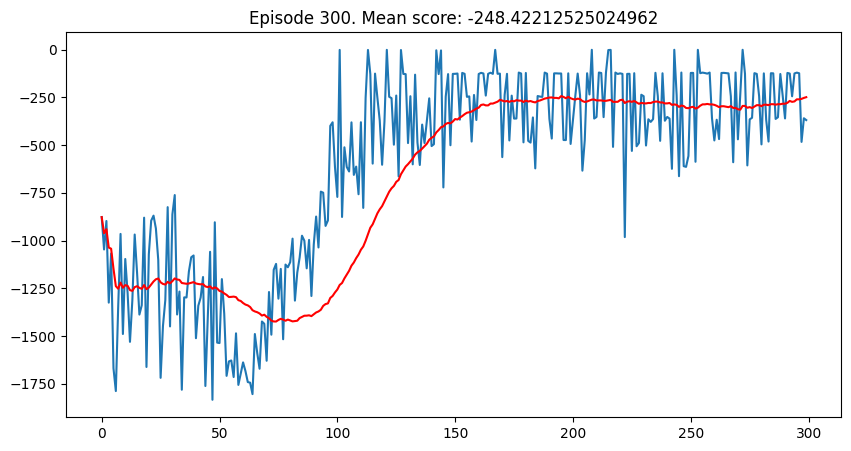

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
allScores, meanScores, actorLosses, criticLosses = train(agent, env, 300, objective=None, plot=True)
saveAgentAndOutputs(agent, allScores, meanScores, actorLosses, criticLosses)

On this cell, we can see the video of the learned behavior. We can see that the pendulum starts in a really complicated position that does not allow it to go left. Hence, the agent decides to apply torque to the right and gain enough, but not too much, momentum to keep it still vertically at the top. This initial position makes the pendulum spend a lot of time out of position, requiring an important torque to make it turn all the way up. This could be one of the reasons it receives an average reward of -250. However, it has to be said that this initial position is also a benefit that helps the pendulum gain inertia without the explicit application of any extra torque.

In [ ]:
oneRun(env_name, agent)

#### **Mountain Car Continuous**

The Mountain Car environment consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the environment is to strategically accelerate the car to reach the goal state on top of the right hill. The whole environment description can be found in [Mountain Car Continuous](https://mgoulao.github.io/gym-docs/environments/classic_control/mountain_car_continuous/).


The action space consists of a single action that indicates the acceleration applied to the car placed in the environment. The range of action is [-1,1] with -1 indicating maximum acceleration backwards, 1 indicating maximum acceleration in the natural car direction, forward, and 0 meaning no acceleration applied. The objective is to gain enough inertia to let the car achieve the flag at the top of the hill as fast as possible, applying the least amount of energy (acceleration force) to achieve it.

In [ ]:
env_name = "MountainCarContinuous-v0"
env = gym.make(env_name, new_step_api=True)

For the second environment, we change a little bit some of the default parameters. We also increased the batch size to 128 because we had seen that 64 was not enough, or, at least, no great difference was spotted. In this case, for the noise parametrization, we kept the original theta and sigma values but used a 0.1 reduction (meaning that we will decrease the noise applied by dividing it by 10). It helped the exploitation phase to restrict to the more useful actions and didn't penalize at all the exploration process.


The gamma was increased to 0.999, as we have seen some other algorithms that used it in this specific environment. The buffer size and tau were kept unchanged, as well as the learning rates. In exactly the same fashion as the previous environment, our agent completes the task in less than 300 episodes, so we have set the number of episodes to 300 with 50 random initial exploration episodes.


In [ ]:
agent = DDPGAgent(obsSpace = env.observation_space,
                  actionSpace = env.action_space,
                  bufferSize = 1e6,
                  batchSize = 128,
                  noiseTheta = 0.15,
                  noiseSigma = 0.2,
                  noiseRed = 0.1,
                  noiseDecay = 1.0,
                  gamma = 0.999,
                  tau = 0.001,
                  lrActor = 0.0001,
                  lrCritic = 0.001,
                  initRandEpisodes = 50,
                  device = device)

It can be seen that around episode 100, the agent already performs almost perfectly in this environment, finding the most useful inertia to achieve the flag on top. It's relevant to mention that the noise is really important in this environment because, with the incorrect choice of parameters, the agent could decide that the best action is just to keep still without moving, which results in a reward of 0. It is not until the car reaches the flag for the first time that it realizes that if it wants to achieve it, it should move. 

We have been lucky with this training process as long as, even with random actions, the car achieves the flag. However, I've tried several times, and when the car doesn't get it, it is quite hard for it to discover it, tending to remain static at the bottom of the curve. The end reduction in reward was just a special case because more episodes were tried and the average kept around the same value.

Overall, this training process took only around 11-12 minutes to be executed.

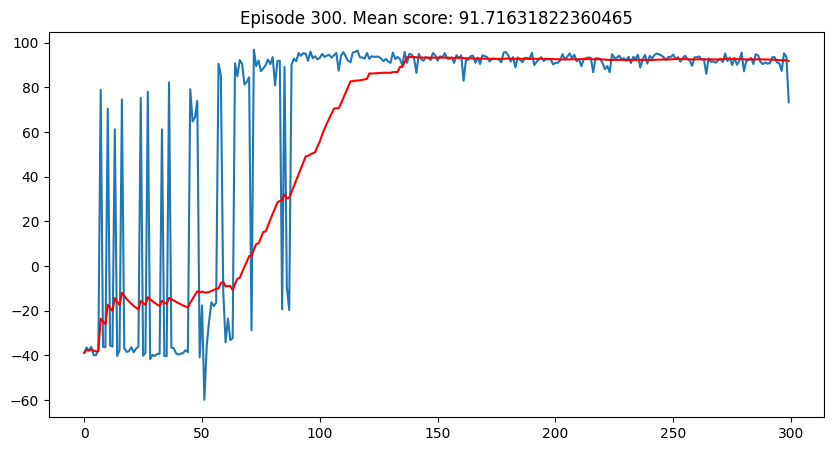

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
allScores, meanScores, actorLosses, criticLosses = train(agent, env, 300, objective=None, plot=True)
saveAgentAndOutputs(agent, allScores, meanScores, actorLosses, criticLosses)

On this cell, we can see the video of the learned behavior for the mountain car continuos. We can see that the car starts at the bottom quite centered and decides to go backwards as hard as it can until it reaches around the middle of the left visible hill. This first movement helps it a lot to gain enough inertia in order to climb through the right hill until the top, achieving the desired flag. In different videos, we have seen that the learned behavior is always the same: going a little bit backward and accelerating as hard as possible to achieve the flag. It may be the case that the car starts too much to the left, and it requires that it first accelerate a little bit to the right to gain the necessary momentum to climb enough of the left hill and accelerate to finally achieve the flag on the other end. In conclusion, we can see that this learned behavior is the most logical and perfect way to intuitively solve this problem.

In [ ]:
oneRun(env_name, agent)

#### **Lunar lander**

This environment is a classic rocket trajectory optimization problem. We are dealing with a continuous environment. The goal of the environment is to strategically descend the rocket carefully to reach the objective landing pad, which is always at coordinates (0, 0). The initial position of the rocket can make the required actions really different. The whole environment description can be found in [Lunar Lander Continuous](https://www.gymlibrary.dev/environments/box2d/lunar_lander/).




In the continuous environment, the action space consists of two actions that indicate the throttle of the main and lateral motors. The range of action is [-1, 1], with some differences in the case of the main and the lateral motors, but with the idea that in the lateral motors the extremes (near +-1) apply either to the left or the right, and near 0 both engines are off. With the main motor, when the value is < 0, it is considered to be off and linearly scales until the maximum value of 1. The objective is to compensate and move the rocket correctly to achieve the landing pad as quickly as possible, applying the least amount of energy (throttle force) to achieve it.

In [ ]:
env_name = "LunarLander-v2"
env = gym.make(env_name, continuous=True, new_step_api=True)

For the last environment, we kept all the default parameters. We tested different noise parametrizations but at the end, the one that achieved the best results, after many different tries with random initializations, was the original paper's defined noise. All the other parameters — the buffer information, gamma, tau, and learning rates — remain untouched as long as they provide enough capabilities to learn this environment.

As long as this environment is quite complex, we increased the number of iterations to 1000 to let it learn much more. So, we also increased the number of initial random episodes to 100 in order to gain insightful experiences to learn from at the exploration phase.


In [ ]:
agent = DDPGAgent(obsSpace = env.observation_space,
                  actionSpace = env.action_space,
                  bufferSize = 1e6,
                  batchSize = 64,
                  noiseTheta = 0.15,
                  noiseSigma = 0.2,
                  noiseRed = 1.0,
                  noiseDecay = 1.0,
                  gamma = 0.99,
                  tau = 0.001,
                  lrActor = 0.0001,
                  lrCritic = 0.001,
                  initRandEpisodes = 100,
                  device = device)

In the mean score plot, we can see how the agent progressively learned how to behave in this environment. Achieving a good solution in about 400 episodes, which were fine tuned to achieve a final mean score of around 220. We can say that it is quite near the perfect solution, and as the official environment page indicates, the environment is solved for around 200 reward points. However, we can see that, even at the end of the learning procedure, there is quite a lot of variability in the reward between 0 and 250.


It is interesting to see how it struggles after the random episode finishes at 100 and how it quickly recovers, achieving much better results around episode 200. Afterwards, the learning procedure was a little bit slow, increasing a little bit until approaching episode 400, where the learning speeds up a little bit. Finally, there are a few variations on the rewards that finally achieve a quite high average reward.

Overall, this training process took around an hour (57 minutes) to be executed.

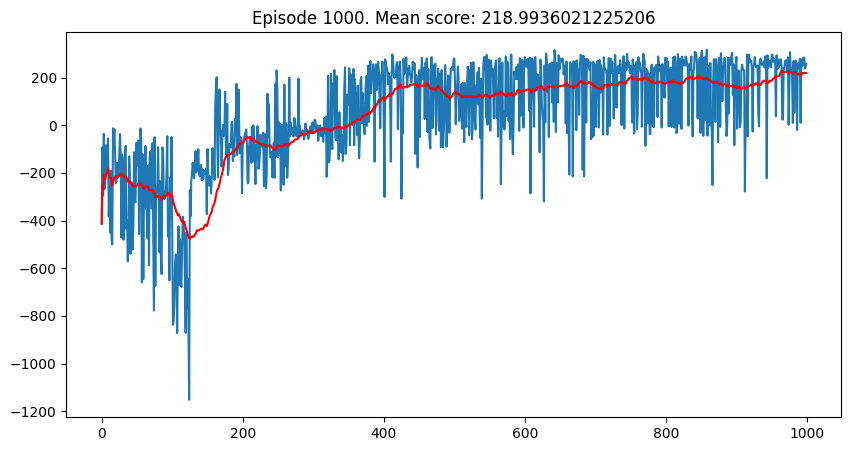

In [ ]:
allScores, meanScores, actorLosses, criticLosses = train(agent, env, 1000, objective=None, plot=True)
saveAgentAndOutputs(agent, allScores, meanScores, actorLosses, criticLosses)

On this cell, we can see the video of the learned behavior for the lunar lander's continuous environment. We can see how smoothly the rocket inclines itself in order to apply a little bit of energy to the main propeller to control the landing velocity. The lateral engines didn't apply much power, which is correct in this initialization as long as no heavy lateral movement is required. We can see that it is really smooth and achieves the landing pad with great capabilities without crashing too hard to the ground. I've tried seeing other videos with different initializations, and they always achieve really good results. With the small exploration performed, no complicated scenarios were found. However, it is true that the high variability of the reward the agent gets showcases that some episodes didn't perform as well as the presented video. This is not a problem but a characteristic of the variability in the initialization of this environment.

In [ ]:
oneRun(env_name, agent, lunar=True)

### **Conclusions**

So, in order to conclude this work, we would like to present some details and insightful knowledge obtained during the implementation process. Lastly, a brief personal analysis and assessment of the algorithm, along with possible future work


With the implementation performed, we have seen that our agent was capable of adapting and solving many different scenarios. We have seen the generalization capability of if and how, by only modifying some of the parameters, it can achieve solutions for different environments. This glimpse shows the powerfulness and adaptability of the method. It has to be mentioned that the networks are not really big, with only two layers of around 350 neurons each, and, even so, they were capable of learning complex behaviors in complex environments. This was quite a surprise to me, who expected, at the start, to be dealing with an implementation that uses big networks to learn the best action to choose depending on the given observation.


It was not easy to achieve a workable implementation, especially for the part of PyTorch's gradient functions with which we're not familiar. We had to perform quite a lot of research on how to backpropagate the loss on PyTorch to achieve a working agent that updates and learns correctly when calling the updateModel function. However, we are really happy with the results obtained, which achieved amazing performance in the three tested environments. We would have liked to use more environments, but the parameter search and the execution time, as well as the Google Colab resources, were drawbacks to doing so.


It is important to mention that each of the environments is completely different from each other, but this didn't affect our agent's ability to solve all of them. However, a great part of tackling the parameters to achieve the best performance in each of the environments was required to allow the agent to overcome the specific difficulties that the environment presented. This allows us to categorize it as a generalizable algorithm that can solve different scenarios efficiently, but we should not forget that every problem is different and specific parametrizations should be applied to each one to achieve the maximum possible rewards.


We have also experienced the problem of "catastrophic forgetting", especially in the harder environment of the lunar lander. With many different parametrizations, we achieved an agent that seemed to learn progressively, but at one point it started to forget how to perform correctly, resulting in a progressive decrease in the agent's performance. To avoid this scenario, we modified the batch size and the exploration noise, trying to make it more stable. However, this problem will persist until we figure out a combination of parameters (exactly the default ones) that works perfectly for it (at least for the learning procedure performed).


Lastly, I would like to mention that I learned a lot about how to implement an apparently hard algorithm directly from the original paper, following the architecture details as well as all the parametrizations within the implementation details section of the paper. Still, it has to be said that, as mentioned, we struggle a little bit more with the usage of the PyTorch backward propagation procedure as we didn't learn about it until now. To conclude, we would like to say that it is a powerful reinforcement learning procedure that can be applied to many environments.


As a last note, we tried the agent with the [Flappy Bird gym](https://github.com/Talendar/flappy-bird-gym) environment. It is a challenging environment that controls the bird in the well-known Flappy Bird game. We made the necessary changes to perform the assignment of discrete functions in this scenario. However, even after achieving some exploration episodes that go through the first pipe, the agent didn't learn how to do so afterward and got stuck in a local minima by always performing the fly action. In the future, we would like to learn how to properly transform this model to let it solve this kind of discrete problem with the same robustness as the ones seen in this notebook.